# Data Visualization
This part will be using to display the Producer Price Index by Commodity: Chemicals and Allied Products: Phosphoric Acid, 52-54 Percent APA, Superphosphates and Other Phosphate Fertilizer Materials (WPU0652026A)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataPath = "/content/drive/MyDrive/Colab Notebooks/CMPE274/hackathon/"
wpuData = "WPU0652026A.csv"
sofiREport = "SOFI-2023.pdf"
mosaicFinanceSEC = "fdd5f871-c414-4ae0-973e-37a5a5472cf2.pdf"

In [3]:
import pandas as pd
import plotly.graph_objects as go
def visualize_pricing_data(dataframe, date_column, value_column):
    fig = go.Figure(data=[go.Scatter(x=dataframe[date_column], y=dataframe[value_column], mode='lines')])
    fig.update_layout(
        title='Producer Price Index by Commodity: Chemicals and Allied Products: Phosphoric Acid, 52-54 Percent APA, Superphosphates and Other Phosphate Fertilizer Materials (WPU0652026A)',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible=True,
            ),
            type='date'
        ),
        yaxis=dict(
            title=value_column
        )
    )
    fig.show()

In [4]:
filePath = dataPath+wpuData
data = pd.read_csv(filePath)
visualize_pricing_data(data, 'DATE', 'WPU0652026A')

# Executive Report and Chatbot


## Building QA System with Haystack and Transformer

In [5]:
!pip install --upgrade pip
# !pip install farm-haystack[colab,ocr,preprocessing,file-conversion,pdf]
!pip install farm-haystack[colab,preprocessing,elasticsearch,inference,file-conversion,pdf]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.4/301.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━

In [20]:
# Enable Telemetry
from haystack.telemetry import tutorial_running
tutorial_running(3)
# setup logging Info
import logging
logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [21]:
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

In [22]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

In [23]:
import time

time.sleep(30)

In [24]:
import os
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.utils import fetch_archive_from_http
from haystack import Pipeline
from haystack.nodes import PDFToTextConverter, PreProcessor

# Set up Elasticsearch connection
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store = ElasticsearchDocumentStore(host=host, port=9200, username="", password="", index="document")

# Setup the components
pdf_converter = PDFToTextConverter(remove_numeric_tables=True, valid_languages=["en"])
preprocessor = PreProcessor(
    clean_whitespace=True,
    clean_header_footer=True,
    clean_empty_lines=True,
    split_by="word",
    split_length=200,
    split_overlap=20,
    split_respect_sentence_boundary=True
)

In [25]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_node(component=pdf_converter, name="PDFToTextConverter", inputs=["File"])
indexing_pipeline.add_node(component=preprocessor, name="PreProcessor", inputs=["PDFToTextConverter"])
indexing_pipeline.add_node(component=document_store, name="DocumentStore", inputs=["PreProcessor"])

In [26]:
dataPath = "/content/drive/MyDrive/Colab Notebooks/CMPE274/hackathon"
wpuData = "WPU0652026A.csv"
sofiREport = "SOFI-2023.pdf"
mosaicFinanceSEC = "fdd5f871-c414-4ae0-973e-37a5a5472cf2.pdf"

doc_dir = dataPath+"/docs"  # Adjust to your PDF files directory
files_to_index = [os.path.join(doc_dir, f) for f in os.listdir(doc_dir) if f.endswith('.pdf')]
indexing_pipeline.run_batch(file_paths=files_to_index)

INFO:haystack.pipelines.base:It seems that an indexing Pipeline is run, so using the nodes' run method instead of run_batch.
Converting files:   0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Preprocessing: 100%|██████████| 2/2 [00:01<00:00,  1.06docs/s]


{'documents': [<Document: {'content': 'Table of Contents\nUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n_______________________________________________________________________\n_______________________________________________________________________\n☑\xa0\xa0\xa0\xa0QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the quarterly period ended September\xa030, 2023\nOR\n☐\xa0\xa0\xa0\xa0\xa0TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 to\nCommission file number 001-32327\n_______________________________________________________________________\nThe Mosaic Company\n(Exact name of registrant as specified in its charter)\n_______________________________________________________________________\n\nDelaware\n(State or other jurisdiction of\nincorporation or organization

In [ ]:
# from haystack.nodes import BM25Retriever

# retriever = BM25Retriever(document_store=document_store)

# from haystack.nodes import FARMReader

# reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)
INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.
INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0


In [ ]:
# from haystack import Pipeline

# querying_pipeline = Pipeline()
# querying_pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
# querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

In [ ]:
# prediction = querying_pipeline.run(
#     query="List major food insecurity reason in 2023?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
# )


In [ ]:
# from pprint import pprint

# pprint(prediction)

In [ ]:
# from haystack.utils import print_answers

# print_answers(prediction, details="minimum")  ## Choose from `minimum`, `medium` and `all`


In [27]:
from collections import defaultdict
from heapq import nlargest
from pprint import pprint

def summarize_prediction(prediction):
    summary = []

    # Extract answers and their scores
    for qa in prediction['answers']:
        context = qa.context
        answer = qa.answer
        score = qa.score

        # Check if context already exists in summary
        context_found = False
        for item in summary:
            if item['context'] == context:
                context_found = True
                item['answers'].append({'answer': answer, 'score': score})
                break

        # If context is not found, add it to summary
        if not context_found:
            summary.append({'context': context, 'answers': [{'answer': answer, 'score': score}]})

    # Generate the summarized text
    summary_text = ""
    for item in summary:
        context = item['context']
        answers = item['answers']
        summary_text += f"{context}:\n"
        for ans in answers:
            summary_text += f"- {ans['answer']} (Score: {ans['score']:.2f})\n"
        summary_text += "\n"

    return summary_text

# Generate summary
# summary = summarize_prediction(prediction)
# print(summary)




In [28]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

def summarize_with_T5(text):
    # Load pre-trained T5 model and tokenizer
    model_name = "t5-small"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Tokenize the text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# incomplete = summarize_with_T5(summary)
# print(incomplete)


In [29]:
# from haystack.nodes import BM25Retriever, FARMReader
# from haystack import Pipeline
# import textwrap
# executiveReport = []
# # Initialize retriever and reader components
# retriever = BM25Retriever(document_store=document_store)
# reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

# # Build the querying pipeline
# querying_pipeline = Pipeline()
# querying_pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
# querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

# # Loop for interactive querying
# while True:
#     # Get user input
#     question = input("You: ")

#     # Exit loop if user input is empty
#     if not question:
#         break

#     # Execute the querying pipeline with the user's question
#     prediction = querying_pipeline.run(
#         query=question,
#         params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
#     )
#     summary = summarize_prediction(prediction)
#     completeSummary = summarize_with_T5(summary)
#     executiveReport.append(completeSummary)
#     print(completeSummary)
#     # Print the prediction
#     # pprint(prediction)
import textwrap
import json
from haystack.nodes import BM25Retriever, FARMReader
from haystack import Pipeline
# Initialize retriever and reader components
retriever = BM25Retriever(document_store=document_store)
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

# Build the querying pipeline
querying_pipeline = Pipeline()
querying_pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

# Initialize the report dictionary
report = {}

# Loop for interactive querying
while True:
    # Get user input
    question = input("You: ")

    # Check if user wants to exit
    if question.lower() == 'exit':
        break

    # Execute the querying pipeline with the user's question
    prediction = querying_pipeline.run(
        query=question,
        params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
    )
    summary = summarize_prediction(prediction)
    completeSummary = summarize_with_T5(summary)

    # Add question and answer to the report dictionary
    report[question] = completeSummary

    # Adjust width of printed text and print with text wrapping
    wrapped_text = textwrap.fill(completeSummary, width=100)
    print(wrapped_text)
    print()  # Empty line for space below

# Once the loop exits, print the report as pretty JSON
print("Report:")
print(json.dumps(report, indent=4))





INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)
INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.
INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0


You: List major food insecurity reason in 2023


Inferencing Samples: 100%|██████████| 1/1 [00:19<00:00, 19.23s/ Batches]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


conflict, climate extremes, economic slowdowns and downturns, and growing inequality (Score: 0.25)
ions like sub-saharan africa and southern Asia have some of the highest numbers of individuals who
are hungry, food insecure and malnourished.

You: Explain malnutrition in war zones


Inferencing Samples: 100%|██████████| 1/1 [00:17<00:00, 17.28s/ Batches]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


the current scenario shows that almost 600 million people will be chronically undernourished in
2030. 119 million more undernourished people than in the scenario in which neither the pandemic nor
the war in Ukraine had occurred. around 23 million more than in the scenario where the war had not
happened.

You: Explain increase prices impact on food security


Inferencing Samples: 100%|██████████| 1/1 [00:21<00:00, 21.23s/ Batches]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


commodity prices were rising steadily even before the war, the added uncertainty induced by the war
contributed to a surge in food prices. such high shares increase the risk of food hoarding when
prices are expected to rise. such high shares increase the risk of food hoarding when prices are
expected to rise.

You: List major Mosaic Influencer in 2023


Inferencing Samples: 100%|██████████| 1/1 [00:14<00:00, 14.94s/ Batches]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Clint C. Freeland Clint C. Freeland Executive Vice President and Chief Financial Officer The Mosaic
Company Certification of Chief Financial Officer Required by Ru: - James "Joc" C. O'Rourke. we will
perform our next annual goodwill impairment analysis for each o: - $ $ $.

You: Compare food security issues in Mosaic and Food Security Document


Inferencing Samples: 100%|██████████| 1/1 [00:20<00:00, 20.75s/ Batches]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


figure 7 shows that, of a total of 2.4 billion people in the world facing food. of a total of 2.4
billion people in the world facing food. of a total of 2.4 billion people in the world facing food.

You: exit
Report:
{
    "List major food insecurity reason in 2023": "conflict, climate extremes, economic slowdowns and downturns, and growing inequality (Score: 0.25) ions like sub-saharan africa and southern Asia have some of the highest numbers of individuals who are hungry, food insecure and malnourished.",
    "Explain malnutrition in war zones": "the current scenario shows that almost 600 million people will be chronically undernourished in 2030. 119 million more undernourished people than in the scenario in which neither the pandemic nor the war in Ukraine had occurred. around 23 million more than in the scenario where the war had not happened.",
    "Explain increase prices impact on food security": "commodity prices were rising steadily even before the war, the added uncertainty i

## Executive Report

In [30]:
print(json.dumps(report, indent=4))

{
    "List major food insecurity reason in 2023": "conflict, climate extremes, economic slowdowns and downturns, and growing inequality (Score: 0.25) ions like sub-saharan africa and southern Asia have some of the highest numbers of individuals who are hungry, food insecure and malnourished.",
    "Explain malnutrition in war zones": "the current scenario shows that almost 600 million people will be chronically undernourished in 2030. 119 million more undernourished people than in the scenario in which neither the pandemic nor the war in Ukraine had occurred. around 23 million more than in the scenario where the war had not happened.",
    "Explain increase prices impact on food security": "commodity prices were rising steadily even before the war, the added uncertainty induced by the war contributed to a surge in food prices. such high shares increase the risk of food hoarding when prices are expected to rise. such high shares increase the risk of food hoarding when prices are expect

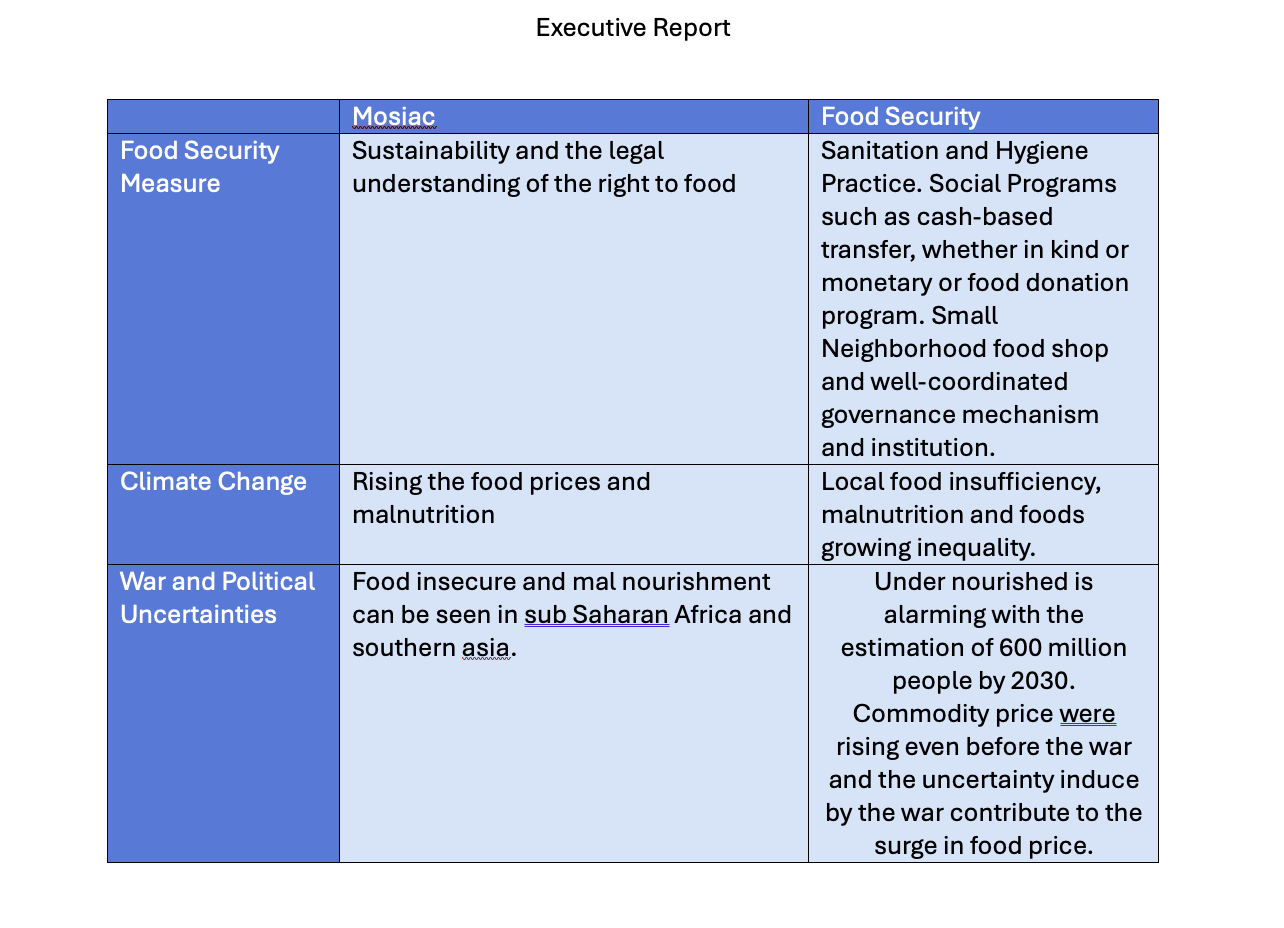

In [19]:
from IPython.display import Image, display
image_path = "/content/drive/MyDrive/Colab Notebooks/CMPE274/hackathon/group/Screenshot 2024-04-21 at 11.07.41 AM.png"

# Display the image
display(Image(image_path))
